In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 95s 2ms/step - loss: 0.2601 - acc: 0.9200 - val_loss: 0.0550 - val_acc: 0.9829
Epoch 2/4
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0874 - acc: 0.9731 - val_loss: 0.0369 - val_acc: 0.9866
Epoch 3/4
 4992/60000 [=>............................] - ETA: 1:21 - loss: 0.0663 - acc: 0.9814

In [1]:
from keras.models import load_model
model = load_model('my_model_mnist.h5')

Using TensorFlow backend.
W0703 20:50:23.427294 26148 deprecation_wrapper.py:119] From C:\Users\prana\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 20:50:23.445722 26148 deprecation_wrapper.py:119] From C:\Users\prana\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 20:50:23.493658 26148 deprecation_wrapper.py:119] From C:\Users\prana\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 20:50:23.496255 26148 deprecation_wrapper.py:119] From C:\Users\prana\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 20:50:23.496255 26148 deprecation_wrapper.py:1

In [2]:
def model_pred(img):
    global model
    return np.argmax(model.predict(img))

In [52]:
import cv2
import numpy as np
import math
import sklearn

In [53]:
def display(img):
    back = np.zeros((500,500,3))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(back,str(model_pred(img)),(100,400), font, 15,(255,255,255),10,cv2.LINE_AA)
    plt.imshow(back,cmap = 'gray')
    plt.show()

In [54]:
def image_processing(store):
    img = store[-1]
    img = img[20:260,:]
    #img = 255 - img
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.erode(img,(3,3),iterations = 3)
    img = cv2.dilate(img,(3,3),iterations = 10)
    #plt.imshow(img,cmap =  'gray')
    img = cv2.resize(img,(28,28))
    #plt.imshow(img,cmap = 'gray')
    img = np.reshape(img,(1,28,28,1))

    return img

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
background = None
accumulated_weight = 0.5

roi_top = 20
roi_bottom = 400
roi_right = 300
roi_left = 600

In [57]:
def calc_accum_avg(frame,accumulated_weight):
    
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame,background,accumulated_weight)

In [58]:
def segment(frame,threshold=25):
    
    global background
    
    diff = cv2.absdiff(background.astype("uint8"),frame)
    _,thresholded = cv2.threshold(diff,threshold,255,cv2.THRESH_BINARY)
    contours,hierarchy =  cv2.findContours(thresholded.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    else:
        hand_segment = max(contours,key = cv2.contourArea)
        return (thresholded,hand_segment)

In [59]:
def dist(a,b):
    return math.sqrt((a[0] - b[0])**2 + (b[1] - a[1])**2)

In [60]:
def filter_points(points,filterValue):
    for i in range(len(points)):
        for j in range(i+1,len(points)):
            if points[i] and points[j] and dist(points[i] , points[j]) < filterValue:
                points[j] = None
    filtered = []
    for point in points:
        if point is not None:
            filtered.append(point)
    return filtered

In [61]:
def plot(frame,points):
    for point in points:
        cv2.circle(frame,point,radius = 5,color = (0,0,255),thickness = -1)

In [62]:
def get_new_screen():
    return np.zeros((380,300))

In [63]:
cam = cv2.VideoCapture(0)
#cam.set(cv2.CAP_PROP_FPS,90)
num_frames = 0
screen = np.zeros((380,300))

store = []

curr = None
prev = None

# keep looping, until interrupted
while True:

    ret, frame = cam.read()

    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[roi_top:roi_bottom, roi_right:roi_left]
    #print(roi.shape)
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    if num_frames < 60:
        calc_accum_avg(gray, accumulated_weight)
        if num_frames <= 59:
            cv2.putText(frame_copy, "WAIT! GETTING BACKGROUND AVG.", (20, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
            cv2.imshow("Finger Count",frame_copy)
            
    else:

        hand = segment(gray)

        if hand is not None:
            thresholded, hand_segment = hand
            masked = cv2.bitwise_and(roi,roi,mask = thresholded)
            #cv2.imshow("Masked",masked)
            #cv2.imshow("Thesholded", thresholded)
            contours,hierarchy = cv2.findContours(thresholded,
                                                  cv2.RETR_TREE,
                                                  cv2.CHAIN_APPROX_SIMPLE)
            palm_area = 0
            flag = None
            cnt = None
            
            for (i,c) in enumerate(contours):
                area = cv2.contourArea(c)
                if area>palm_area:
                    palm_area = area
                    flag = i
            if flag is not None and palm_area > 10000:
                cnt = contours[flag]
                cv2.drawContours(masked,[cnt],0,(0,255,0),2)
                cv2.imshow("roi_contours",masked)
                points = []
                hull = cv2.convexHull(cnt,returnPoints = False)
                defects = cv2.convexityDefects(cnt,hull)
                
                for i in range(defects.shape[0]):
                    s,e,f,d, = defects[i,0]
                    end = tuple(cnt[e][0])
                    points.append(end)
    
                filtered = filter_points(points,50)#.sort(key = lambda x:x[1])
                filtered.sort(key = lambda point : point[1])
                fingers = [pt for (idx,pt) in zip(range(1),filtered)]
                plot(masked,fingers)
    
                cv2.imshow("roi_contours",masked)
               
                prev = curr
                curr = fingers[0]
                
                if prev and curr:
                    cv2.line(screen,prev,curr,(255,255,255),3)
                cv2.imshow("Drawing",screen)
                
                
                k = cv2.waitKey(10)
                if k == ord('a'):
                    store.append(screen)
                    screen = get_new_screen()
                      
    cv2.rectangle(frame_copy, (roi_left, roi_top), (roi_right, roi_bottom), (0,0,255), 5)

    num_frames += 1
    cv2.imshow("Finger Count", frame_copy)

    k = cv2.waitKey(12) & 0xFF
    if k == 27:
        break
        
cam.release()
cv2.destroyAllWindows()

In [18]:
img = image_processing(store)

W0703 20:59:35.154932 26148 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


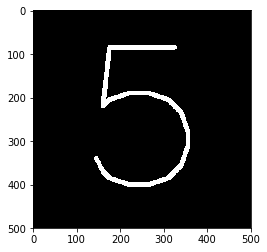

In [51]:
display(img)